In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ipywidgets import interact, IntSlider
import os
import requests


In [23]:
url = 'https://nist-assets.s3.us-east-1.amazonaws.com/shake.mp4'
os.makedirs('tmp', exist_ok=True)
with open('tmp/shake.mp4', 'wb') as f:
    f.write(requests.get(url).content)

# read with OpenCV
cap = cv2.VideoCapture('tmp/shake.mp4')


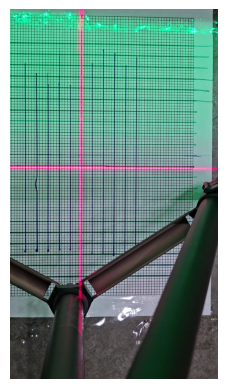

In [24]:
frame_path = 'assets/frame.png'
frame_bgr = cv2.imread(frame_path)
frame_hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)
plt.axis('off')
plt.show()

[[array([150, 100, 100]), array([179, 255, 255])],
 [array([  0, 100, 100]), array([ 10, 255, 255])]]

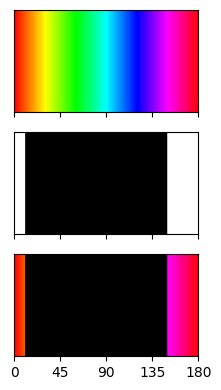

In [25]:
def show_hue_range(start_hue: int, hue_length: int, s_min=100, v_min=100, axes=None):
    # Create horizontal HSV gradient
    height, width = 100, 180
    h = np.linspace(0, 179, width).astype(np.uint8)
    s = np.full((height,), 255, dtype=np.uint8)
    v = np.full((height,), 255, dtype=np.uint8)

    hsv_img = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(width):
        hsv_img[:, i, 0] = h[i]
        hsv_img[:, i, 1] = s
        hsv_img[:, i, 2] = v

    # Convert to RGB for display
    rgb_img = cv2.cvtColor(cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2RGB)

    # Compute range
    end_hue = (start_hue + hue_length) % 180

    if hue_length <= 0:
        raise ValueError("hue_length must be > 0")

    # Handle wrapping
    if start_hue < end_hue:
        lower = np.array([start_hue, s_min, v_min])
        upper = np.array([end_hue, 255, 255])
        mask = cv2.inRange(hsv_img, lower, upper)
    else:
        lower1 = np.array([start_hue, s_min, v_min])
        upper1 = np.array([179, 255, 255])
        lower2 = np.array([0, s_min, v_min])
        upper2 = np.array([end_hue, 255, 255])
        mask1 = cv2.inRange(hsv_img, lower1, upper1)
        mask2 = cv2.inRange(hsv_img, lower2, upper2)
        mask = cv2.bitwise_or(mask1, mask2)

    result = cv2.bitwise_and(rgb_img, rgb_img, mask=mask)

    # Plot
    axes[0].imshow(rgb_img)
    axes[1].imshow(mask, cmap='gray')
    axes[2].imshow(result)
    for a in axes:
        a.set_yticks([])
        a.set_xticks([0, 45, 90, 135, 180])
    
    if start_hue < end_hue:
        return [[lower, upper]]
    else:
        return [[lower1, upper1], [lower2, upper2]]

fig, axes = plt.subplots(3, 1, figsize=(15, 4), sharex=True)

start_hue = 150
hue_length = 40

hue_range = show_hue_range(start_hue=start_hue, hue_length=hue_length, axes=axes)
fig.tight_layout()

hue_range

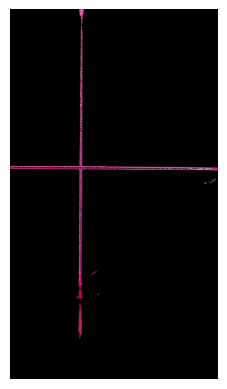

In [26]:
mask1 = cv2.inRange(frame_hsv, hue_range[0][0], hue_range[0][1])
mask2 = cv2.inRange(frame_hsv, hue_range[1][0], hue_range[1][1])
red_mask = cv2.bitwise_or(mask1, mask2)

frame_masked = cv2.bitwise_and(frame_rgb, frame_rgb, mask=red_mask)
plt.imshow(frame_masked)
plt.axis('off')
plt.show()

In [31]:
def show_hue_range(start_hue: int, hue_length: int, s_min=100, v_min=100, axes=None):
    height, width = 100, 180
    # build an HSV gradient (H varies from 0 to 179 left to right)
    h = np.linspace(0, 179, width).astype(np.uint8)
    s = np.full((height,), 255, dtype=np.uint8)
    v = np.full((height,), 255, dtype=np.uint8)

    hsv_img = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(width):
        hsv_img[:, i, 0] = h[i]
        hsv_img[:, i, 1] = s
        hsv_img[:, i, 2] = v

    # Convert to RGB for display
    rgb_img = cv2.cvtColor(
        cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR),
        cv2.COLOR_BGR2RGB
    )

    # Compute wrap‐around hue interval
    end_hue = (start_hue + hue_length) % 180
    if hue_length <= 0:
        raise ValueError("hue_length must be > 0")

    # Build binary mask over hsv_img
    if start_hue < end_hue:
        lower = np.array([start_hue, s_min, v_min])
        upper = np.array([end_hue, 255, 255])
        mask = cv2.inRange(hsv_img, lower, upper)
    else:
        # wraps around 179 to 0
        lower1 = np.array([start_hue, s_min, v_min])
        upper1 = np.array([179, 255, 255])
        lower2 = np.array([0, s_min, v_min])
        upper2 = np.array([end_hue, 255, 255])
        mask1 = cv2.inRange(hsv_img, lower1, upper1)
        mask2 = cv2.inRange(hsv_img, lower2, upper2)
        mask = cv2.bitwise_or(mask1, mask2)

    # Apply mask to the RGB gradient
    masked_grad = cv2.bitwise_and(rgb_img, rgb_img, mask=mask)

    # Plot
    axes[0].imshow(rgb_img)
    axes[1].imshow(masked_grad)

    for a in axes:
        a.set_yticks([])
        a.set_xticks([0, 45, 90, 135, 180])


def interactive_layout(start_hue: int, hue_length: int):
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.05)

    # Left column subplots
    ax_grad    = fig.add_subplot(gs[0, 0])
    ax_masked = fig.add_subplot(gs[1, 0])
    left_axes = [ax_grad, ax_masked]

    # Right‐column subplot spanning all 3 rows (cols=1, rows=0:3)
    ax_frame = fig.add_subplot(gs[:, 1])

    # Draw gradients
    show_hue_range(start_hue, hue_length, axes=left_axes)

    # Build the same mask over actual frame_hsv
    end_hue = (start_hue + hue_length) % 180
    if start_hue < end_hue:
        lower = np.array([start_hue, 100, 100])
        upper = np.array([end_hue, 255, 255])
        mask = cv2.inRange(frame_hsv, lower, upper)
    else:
        lower1 = np.array([start_hue, 100, 100])
        upper1 = np.array([179, 255, 255])
        lower2 = np.array([0   , 100, 100])
        upper2 = np.array([end_hue, 255, 255])
        m1 = cv2.inRange(frame_hsv, lower1, upper1)
        m2 = cv2.inRange(frame_hsv, lower2, upper2)
        mask = cv2.bitwise_or(m1, m2)

    # Apply that mask to the RGB version of the frame
    frame_masked = cv2.bitwise_and(frame_rgb, frame_rgb, mask=mask)

    # Show the masked frame on the right, spanning all rows
    ax_frame.imshow(frame_masked)
    ax_frame.axis("off")

interact(
    interactive_layout,
    start_hue=IntSlider(
        min=0, max=179, step=1, value=150, description="Start Hue"
    ),
    hue_length=IntSlider(
        min=1, max=180, step=1, value=40, description="Hue Length"
    )
)


interactive(children=(IntSlider(value=150, description='Start Hue', max=179), IntSlider(value=40, description=…

<function __main__.interactive_layout(start_hue: int, hue_length: int)>